In [6]:
# Only if running this notebook inside the repository tree
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
import numpy as np
import pandas as pd

from causalml.inference.tree import BART
from causalml.metrics import get_cumgain
from causalml.dataset import synthetic_data
from causalml.metrics import plot_gain

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.datasets import make_regression, make_classification
from sklearn.metrics import mean_squared_error, classification_report

from causalml.inference.meta import BaseXRegressor, BaseRRegressor, BaseSRegressor, BaseTRegressor
from causalml.propensity import ElasticNetPropensityModel
from causalml.metrics import *
from causalml.dataset import simulate_hidden_confounder

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error as mse
from scipy.stats import entropy
import warnings
import logging

SEED = 42
FIGSIZE = (15, 5)

np.random.seed(SEED)
plt.rcParams['figure.figsize'] = FIGSIZE

## Classic ML Validation

In [2]:
X, y = make_regression(n_samples=1000, n_features=1, n_informative=1, random_state=SEED)
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=pd.qcut(y, 10), test_size=0.25, random_state=SEED)

bart = BART(m=35)
bart.fit(X=X_train, y=y_train, max_iter=50)

100%|███████████████████████████████████████████████████████████████| 50/50 [00:32<00:00,  1.53it/s]


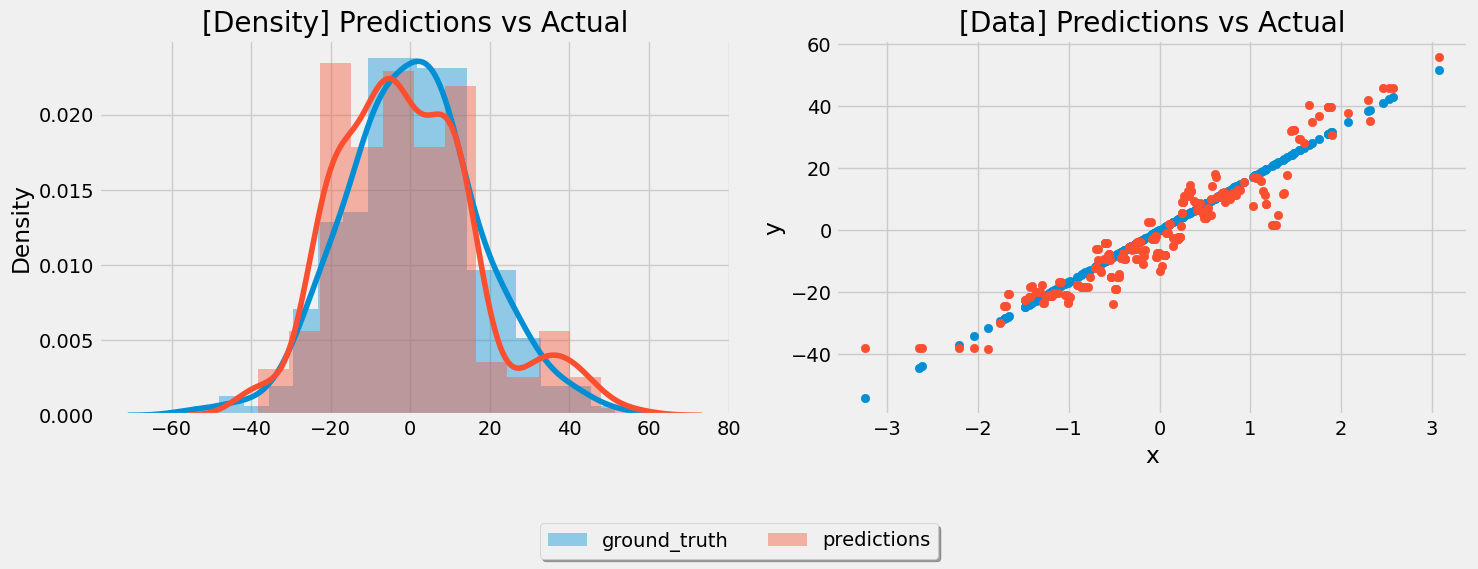

In [3]:
f, (ax1, ax2) = plt.subplots(1, 2)

y_pred = bart.predict(X_test, rescale=True)
sns.distplot(y_test, label='ground_truth', ax=ax1)
sns.distplot(y_pred.flatten(), label='predictions', ax=ax1)
ax1.set_title('[Density] Predictions vs Actual')

ax2.scatter(X_test, y_test, label='_nolegend_')
ax2.scatter(X_test, y_pred, label='_nolegend_')
ax2.set_title('[Data] Predictions vs Actual')
ax2.set_xlabel('x')
ax2.set_ylabel('y')
f.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
          fancybox=True, shadow=True, ncol=5)
plt.tight_layout()
plt.show();

## Uplift Modeling

In [ ]:
y, X, w, tau, b, e = synthetic_data()
X_train, X_test, y_train, y_test = train_test_split(np.concatenate([X, 
                                                                    w.reshape(-1, 1), 
                                                                    tau.reshape(-1, 1)], 
                                                                   axis=1), 
                                                    y, 
                                                    stratify=pd.qcut(y, 10), 
                                                    test_size=0.25, 
                                                    random_state=SEED)
tau_train = X_train[:, -1].reshape(-1, 1)
w_train = X_train[:, -2].reshape(-1, 1)
X_train = X_train[:, :-2]
tau_test = X_test[:, -1].reshape(-1, 1)
w_test = X_test[:, -2].reshape(-1, 1)
X_test = X_test[:, :-2]

bart = BART(m=35)
bart.fit(X=X_train, treatment=w_train, y=y_train, max_iter=50)

y_pred = bart.predict(X_test, rescale=True)
df_preds = pd.DataFrame({'BART':y_pred.flatten(), 
                         'tau':tau_test.flatten(), 
                         'w':w_test.flatten(), 
                         'y': y_test.flatten()})

plot_gain(df_preds, figsize=FIGSIZE, normalize=True)

In [14]:
y, X, w, tau, b, e = simulate_hidden_confounder(n=100000, p=5, sigma=1.0, adj=0.)

X_train, X_val, y_train, y_val, w_train, w_val, tau_train, tau_val, b_train, b_val, e_train, e_val = \
    train_test_split(X, y, w, tau, b, e, test_size=0.2, random_state=123, shuffle=True)

preds_dict_train = {}
preds_dict_valid = {}

preds_dict_train['Actuals'] = tau_train
preds_dict_valid['Actuals'] = tau_val

preds_dict_train['generated_data'] = {
    'y': y_train,
    'X': X_train,
    'w': w_train,
    'tau': tau_train,
    'b': b_train,
    'e': e_train}
preds_dict_valid['generated_data'] = {
    'y': y_val,
    'X': X_val,
    'w': w_val,
    'tau': tau_val,
    'b': b_val,
    'e': e_val}

# Predict p_hat because e would not be directly observed in real-life
p_model = ElasticNetPropensityModel()
p_hat_train = p_model.fit_predict(X_train, w_train)
p_hat_val = p_model.fit_predict(X_val, w_val)

for base_learner, label_l in tqdm(zip([BaseSRegressor, BaseTRegressor, BaseXRegressor, BaseRRegressor],
                                 ['S', 'T', 'X', 'R']), position=0, leave=True):
    for model, label_m in zip([LinearRegression, XGBRegressor], ['LR', 'XGB']):
        # RLearner will need to fit on the p_hat
        if label_l != 'R':
            learner = base_learner(model())
            # fit the model on training data only
            learner.fit(X=X_train, treatment=w_train, y=y_train)
            try:
                preds_dict_train['{} Learner ({})'.format(
                    label_l, label_m)] = learner.predict(X=X_train, p=p_hat_train).flatten()
                preds_dict_valid['{} Learner ({})'.format(
                    label_l, label_m)] = learner.predict(X=X_val, p=p_hat_val).flatten()
            except TypeError:
                preds_dict_train['{} Learner ({})'.format(
                    label_l, label_m)] = learner.predict(X=X_train, treatment=w_train, y=y_train).flatten()
                preds_dict_valid['{} Learner ({})'.format(
                    label_l, label_m)] = learner.predict(X=X_val, treatment=w_val, y=y_val).flatten()
        else:
            learner = base_learner(model())
            learner.fit(X=X_train, p=p_hat_train, treatment=w_train, y=y_train)
            preds_dict_train['{} Learner ({})'.format(
                label_l, label_m)] = learner.predict(X=X_train).flatten()
            preds_dict_valid['{} Learner ({})'.format(
                label_l, label_m)] = learner.predict(X=X_val).flatten()

4it [00:23,  5.82s/it]

training BART


TypeError: __init__() got an unexpected keyword argument 'max_iter'

In [21]:
print(f'training BART')
bart = BART(m=35)
bart.fit(X_train, y_train, treatment=w_train.reshape(-1, 1), max_iter=25)
# preds_dict_train['BART'] = bart.predict(X=X_train, y_train, treatment=w_train).flatten()
# bart_preds = bart.predict(X=X_train, y=y_train, treatment=w_train.reshape(-1, 1))#.flatten()

actuals_train = preds_dict_train['Actuals']

training BART


100%|███████████████████████████████████████████████████████████████| 25/25 [20:09<00:00, 48.36s/it]


TypeError: predict() got an unexpected keyword argument 'y'

In [23]:
bart_preds = bart.predict(X=X_train)#.flatten()

In [24]:
bart_preds

array([[0.160419  ],
       [0.1665807 ],
       [0.16545895],
       ...,
       [0.2081744 ],
       [0.22717441],
       [0.15944725]])

In [18]:
w_train.shape

(80000,)

In [29]:

actuals_validation = preds_dict_valid['Actuals']

synthetic_summary_train = pd.DataFrame({label: [preds.mean(), mse(preds, actuals_train)] for label, preds
                                        in preds_dict_train.items() if 'generated' not in label.lower()},
                                       index=['ATE', 'MSE']).T
synthetic_summary_train['Abs % Error of ATE'] = np.abs(
    (synthetic_summary_train['ATE']/synthetic_summary_train.loc['Actuals', 'ATE']) - 1)

synthetic_summary_validation = pd.DataFrame({label: [preds.mean(), mse(preds, actuals_validation)]
                                             for label, preds in preds_dict_valid.items()
                                             if 'generated' not in label.lower()},
                                            index=['ATE', 'MSE']).T
synthetic_summary_validation['Abs % Error of ATE'] = np.abs(
    (synthetic_summary_validation['ATE']/synthetic_summary_validation.loc['Actuals', 'ATE']) - 1)

# calculate kl divergence for training
for label in synthetic_summary_train.index:
    stacked_values = np.hstack((preds_dict_train[label], actuals_train))
    stacked_low = np.percentile(stacked_values, 0.1)
    stacked_high = np.percentile(stacked_values, 99.9)
    bins = np.linspace(stacked_low, stacked_high, 100)

    distr = np.histogram(preds_dict_train[label], bins=bins)[0]
    distr = np.clip(distr/distr.sum(), 0.001, 0.999)
    true_distr = np.histogram(actuals_train, bins=bins)[0]
    true_distr = np.clip(true_distr/true_distr.sum(), 0.001, 0.999)

    kl = entropy(distr, true_distr)
    synthetic_summary_train.loc[label, 'KL Divergence'] = kl

# calculate kl divergence for validation
for label in synthetic_summary_validation.index:
    stacked_values = np.hstack((preds_dict_valid[label], actuals_validation))
    stacked_low = np.percentile(stacked_values, 0.1)
    stacked_high = np.percentile(stacked_values, 99.9)
    bins = np.linspace(stacked_low, stacked_high, 100)

    distr = np.histogram(preds_dict_valid[label], bins=bins)[0]
    distr = np.clip(distr/distr.sum(), 0.001, 0.999)
    true_distr = np.histogram(actuals_validation, bins=bins)[0]
    true_distr = np.clip(true_distr/true_distr.sum(), 0.001, 0.999)

    kl = entropy(distr, true_distr)
    synthetic_summary_validation.loc[label, 'KL Divergence'] = kl
    
df_preds_train = pd.DataFrame([preds_dict_train['S Learner (LR)'].ravel(),
                               preds_dict_train['S Learner (XGB)'].ravel(),
                               preds_dict_train['T Learner (LR)'].ravel(),
                               preds_dict_train['T Learner (XGB)'].ravel(),
                               preds_dict_train['X Learner (LR)'].ravel(),
                               preds_dict_train['X Learner (XGB)'].ravel(),
                               preds_dict_train['R Learner (LR)'].ravel(),
                               preds_dict_train['R Learner (XGB)'].ravel(),                               
                               preds_dict_train['generated_data']['tau'].ravel(),
                               preds_dict_train['generated_data']['w'].ravel(),
                               preds_dict_train['generated_data']['y'].ravel(),
                               preds_dict_train['BART'].ravel()],
                              index=['S Learner (LR)','S Learner (XGB)',
                                     'T Learner (LR)','T Learner (XGB)',
                                     'X Learner (LR)','X Learner (XGB)',
                                     'R Learner (LR)','R Learner (XGB)',
                                     'tau','w','y', 'BART']).T

synthetic_summary_train['AUUC'] = auuc_score(df_preds_train).iloc[:-1]
df_preds_validation = pd.DataFrame([preds_dict_valid['S Learner (LR)'].ravel(),
                                    preds_dict_valid['S Learner (XGB)'].ravel(),
                                    preds_dict_valid['T Learner (LR)'].ravel(),
                                    preds_dict_valid['T Learner (XGB)'].ravel(),
                                    preds_dict_valid['X Learner (LR)'].ravel(),
                                    preds_dict_valid['X Learner (XGB)'].ravel(),
                                    preds_dict_valid['R Learner (LR)'].ravel(),
                                    preds_dict_valid['R Learner (XGB)'].ravel(),                               
                                    preds_dict_valid['generated_data']['tau'].ravel(),
                                    preds_dict_valid['generated_data']['w'].ravel(),
                                    preds_dict_valid['generated_data']['y'].ravel(), 
                                    preds_dict_valid['BART'].ravel()],
                              index=['S Learner (LR)','S Learner (XGB)',
                                     'T Learner (LR)','T Learner (XGB)',
                                     'X Learner (LR)','X Learner (XGB)',
                                     'R Learner (LR)','R Learner (XGB)',
                                     'tau','w','y', 'BART']).T

synthetic_summary_validation['AUUC'] = auuc_score(df_preds_validation).iloc[:-1]
synthetic_summary_train

KeyError: 'BART'

In [ ]:
from tqdm import tqdm